## KNN:k-nearest neighbor classifier,K最近傍法

In [1]:
#import文
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,KFold,cross_validate
import optuna

C:\Users\imyme\anaconda3\envs\flask\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#DataFrameを作成
df_train=pd.read_csv('../main/data/train.csv')
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0


## 前処理
- ChestPainType:TAとATAをTA+ATAにまとめる
- ST_SlopのFlatとDownをまとめる(FlatとDownの分布が似ている、Downの数が少ない)
- カテゴリ-変数はlabel encoding(mapで順序指定)


In [6]:
#特徴量作成
df_train['H_risk']='Risk0'
for i in range(len(df_train)):
    if abs(df_train.loc[i,'Oldpeak'])<0.3 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='Risk4'
    elif 0.3<=df_train.loc[i,'Oldpeak']<1.3 and df_train.loc[i,'ST_Slope']=='Up':
        df_train.loc[i,'H_risk']='Risk1'
    elif 0.3<=df_train.loc[i,'Oldpeak']<1.3 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='Risk2'
    elif 1.3<=df_train.loc[i,'Oldpeak']<1.9:
        df_train.loc[i,'H_risk']='Risk3'
    elif df_train.loc[i,'Oldpeak']>=2.0 or df_train.loc[i,'Oldpeak']<=-0.3:
        df_train.loc[i,'H_risk']='Risk5'
    else:
        pass
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1,Risk5
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0,Risk0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1,Risk4
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,Risk0
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0,Risk0


In [7]:
pd.crosstab(df_train['H_risk'],df_train['HeartDisease'])

HeartDisease,0,1
H_risk,,
Risk0,188,23
Risk1,28,13
Risk2,31,73
Risk3,16,57
Risk4,7,75
Risk5,13,118


In [13]:
df_train.query('H_risk=="Risk4"').query('Cholesterol==0')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk
15,51,1,ASY,95,0,1,Normal,126,0,2.2,Flat,1,Risk4
33,66,1,ASY,150,0,0,Normal,108,1,2.0,Flat,1,Risk4
80,64,1,ASY,120,0,1,ST,106,0,2.0,Flat,1,Risk4
135,57,1,ASY,140,0,0,Normal,120,1,2.0,Flat,1,Risk4
138,61,1,ASY,150,0,0,Normal,117,1,2.0,Flat,1,Risk4
142,61,1,ASY,110,0,1,Normal,108,1,2.0,Down,1,Risk4
152,63,1,ASY,140,0,1,LVH,149,0,2.0,Up,1,Risk4
199,60,1,ASY,120,0,0,Normal,133,1,2.0,Up,0,Risk4
228,52,1,ASY,135,0,1,Normal,128,1,2.0,Flat,1,Risk4
248,60,1,NAP,115,0,1,Normal,143,0,2.4,Up,1,Risk4


In [29]:
##cholesterolの特徴量作成:CholCat
df_train['CholCat']='chol0'
for i in range(len(df_train)):
    if 200>df_train.loc[i,'Cholesterol']>0:
        df_train.loc[i,'CholCat']='chol1'
    elif 320>df_train.loc[i,'Cholesterol']>=200:
        df_train.loc[i,'CholCat']='chol2'
    elif df_train.loc[i,'Cholesterol']>=320:
        df_train.loc[i,'CholCat']='chol3'
    else:
        pass
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk,CholCat
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1,Risk5,chol3
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0,Risk0,chol3
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1,Risk4,chol0
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,Risk0,chol0
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0,Risk0,chol2


In [30]:
#その他の特徴量の前処理

#ChestPainTypeを特徴量に入れる場合以下を実行

#TAとATAをTA+ATAとする(分布が似ているかつカテゴリー中のデータ数が少ないため)
df_train.loc[df_train['ChestPainType']=='TA','ChestPainType']='TA+ATA'
df_train.loc[df_train['ChestPainType']=='ATA','ChestPainType']='TA+ATA'
#df_train['ChestPainType'].unique()



#OneHotencoder(必要な分だけ)
#ChestPainType,RestingECG,ST_SlopをOneHotEncoding
#df_train=df_train.join(pd.get_dummies(df_train['ChestPainType']))
#df_train=df_train.join(pd.get_dummies(df_train['RestingECG']))
#df_train=df_train.join(pd.get_dummies(df_train['CholCat']))
#df_train=df_train.join(pd.get_dummies(df_train['H_risk']))


#特徴量に使用する連続値のデータを標準化
#データ標準化する対象を選択
numeric_features=['Age','RestingBP', 'MaxHR']

#標準化したデータを元のデータに入れる
#_zで標準化したデータに対応
SS=StandardScaler()
df_train[['Age_z','RestingBP_z','MaxHR_z']]=SS.fit_transform(df_train[numeric_features].values)

df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk,CholCat,Age_z,RestingBP_z,MaxHR_z
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1,Risk5,chol3,0.256306,1.272672,0.512265
1,55,0,TA+ATA,130,394,0,LVH,150,0,0.0,Up,0,Risk0,chol3,0.151431,-0.116784,0.512265
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1,Risk4,chol0,-0.687567,-1.228348,-0.706992
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,Risk0,chol0,-2.050938,-0.950457,0.674833
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0,Risk0,chol2,0.046557,1.550563,1.040610


In [7]:
#DownとFlatは同じ傾向に見えるのと、Downが少ないためまとめる
#df_train.loc[df_train['ST_Slope']=='Down','ST_Slope']='FlatorDown'
#df_train.loc[df_train['ST_Slope']=='Flat','ST_Slope']='FlatorDown'
#df_train['ST_Slope'].unique()

array(['FlatorDown', 'Up'], dtype=object)

In [31]:
#ラベルエンコーダーでエンコーディング
CPT_mapping = {'ASY':2, 'TA+ATA':1, 'NAP':0}
df_train['cpt_l'] = df_train['ChestPainType'].map(CPT_mapping)

RECG_mapping = {'ST':2, 'LVH':1, 'Normal':0}
df_train['recg_l'] = df_train['RestingECG'].map(RECG_mapping)

Hrisk_mapping = {'Risk0':0, 'Risk1':1, 'Risk2':2,'Risk3':3,'Risk4':4,'Risk5':5}
df_train['H_risk_l'] = df_train['H_risk'].map(Hrisk_mapping)

Chol_mapping = {'chol0':4, 'chol1':0, 'chol2':1,'chol3':2}
df_train['chol_l'] = df_train['CholCat'].map(Chol_mapping)


#le = LabelEncoder()
#df_train["ChestPainType"] = le.fit_transform(df_train["ChestPainType"])
#df_train["RestingECG"] = le.fit_transform(df_train["RestingECG"])
#df_train["ST_Slope"] = le.fit_transform(df_train["ST_Slope"])
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,HeartDisease,H_risk,CholCat,Age_z,RestingBP_z,MaxHR_z,cpt_l,recg_l,H_risk_l,chol_l
0,56,1,ASY,155,342,1,Normal,150,1,3.0,...,1,Risk5,chol3,0.256306,1.272672,0.512265,2,0,5,2
1,55,0,TA+ATA,130,394,0,LVH,150,0,0.0,...,0,Risk0,chol3,0.151431,-0.116784,0.512265,1,1,0,2
2,47,1,NAP,110,0,1,Normal,120,1,0.0,...,1,Risk4,chol0,-0.687567,-1.228348,-0.706992,0,0,4,4
3,34,1,ASY,115,0,1,Normal,154,0,0.2,...,1,Risk0,chol0,-2.050938,-0.950457,0.674833,2,0,0,4
4,54,0,NAP,160,201,0,Normal,163,0,0.0,...,0,Risk0,chol2,0.046557,1.550563,1.040610,0,0,0,1


In [32]:
df_train.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'H_risk', 'CholCat', 'Age_z', 'RestingBP_z', 'MaxHR_z',
       'cpt_l', 'recg_l', 'H_risk_l', 'chol_l'],
      dtype='object')

In [33]:
#特徴量と目的変数にデータを分割
features=['Age_z', 'Sex','recg_l','cpt_l','FastingBS','RestingBP_z','ExerciseAngina','MaxHR_z','H_risk_l','chol_l']
target='HeartDisease'

In [34]:
#FutureWarningを消す
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [49]:
KNN=KNeighborsClassifier(n_neighbors=28,p=1,metric='minkowski')

#5分割公差検証
#変数
X = df_train[features] #pcaなし:feature pcaあり:pca_features
Y = df_train[target]

#交差検証
score_LC = cross_val_score(KNN, X, Y, cv=5) 

In [50]:
#正解率を出力する
print(f"スコア LC 交差バージョン: {score_LC}")
print("")

#平均値を出力する
print(f"平均値 LC 交差バージョン： {score_LC.mean()}")
print("")

スコア LC 交差バージョン: [0.86821705 0.89147287 0.9296875  0.875      0.8984375 ]

平均値 LC 交差バージョン： 0.8925629844961239



In [51]:

#Kfoldでtrainとtestのindexを取得
kf = KFold(n_splits=5,shuffle=True,random_state=46)

#df_trainの行を準備
df_train[['KNN_prob','KNN_pred']]=0

val_pred=[]
val_lists=[]
val_pred_acc=[]

#foldした分だけpredictを回す(公差検証)
for i,(train_index,val_index) in enumerate(kf.split(df_train)):
    
    #validationのindexを取得
    val_lists.append(val_index)
    
    #それぞれのモデルのfit
    KNN.fit(X.loc[train_index,:],Y[train_index])

    #それぞれのモデルでtestをpredict_prabaして確率を保存
    KNN_proba=KNN.predict_proba(X.loc[val_index,:])
    
    #df_trainに心臓病確率を入れる
    df_train.loc[val_index,'KNN_prob']=KNN_proba[:,1]

    #df_trainに心臓病予測を入れる
    df_train.loc[val_index,'KNN_pred']=KNN.predict(X.loc[val_index,:])
    
    #正答率をリストに入れる
    val_pred_acc.append(accuracy_score(df_train.loc[val_index,'HeartDisease'].values,df_train.loc[val_index,'KNN_pred'].values))
    

    
#公差検証の結果
print('5分割:',val_pred_acc)
print('5分割平均:',sum(val_pred_acc)/len(val_pred_acc))

#データ全体の正答率
print('全体:',accuracy_score(df_train['HeartDisease'].values,df_train['KNN_pred'].values))

5分割: [0.9224806201550387, 0.8682170542635659, 0.875, 0.9296875, 0.8515625]
5分割平均: 0.8893895348837209
全体: 0.8894080996884736


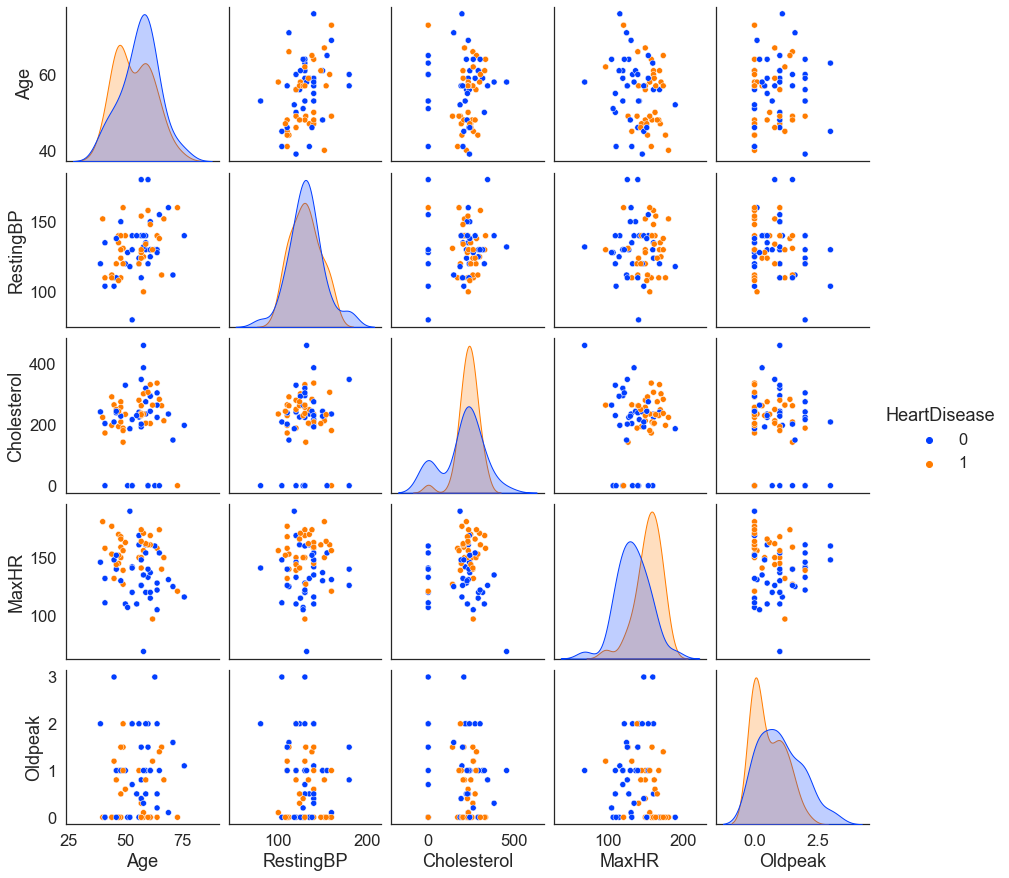

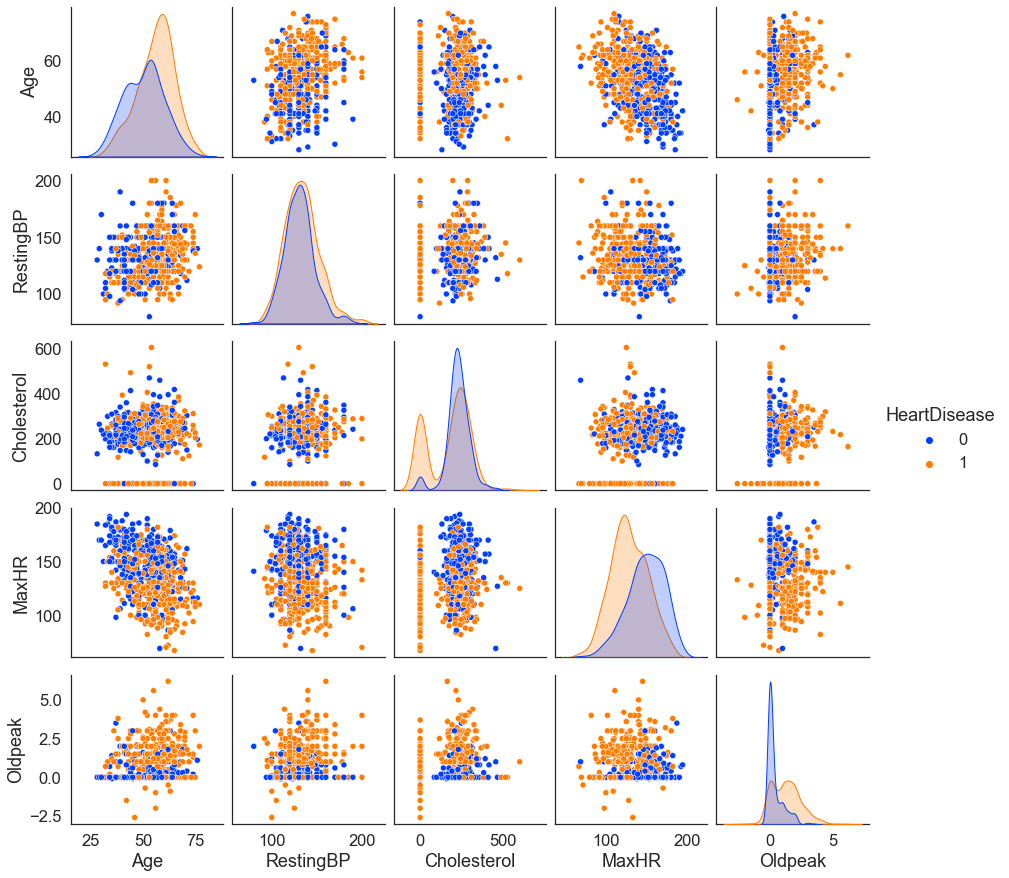

In [52]:
#正解の場合"1"になる列を作成

#seabornのグラフ設定
sns.set(font_scale=1.5,style='white',palette='bright')

df_train['ACC_KNN']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'KNN_pred']:
        df_train.loc[i,'ACC_KNN']=1
    else:
        pass


#間違いだけのデータフレーム作成
df_train_wrong=df_train.copy()
df_train_wrong=df_train_wrong.query('ACC_KNN==0')

#pairplotの作成,心臓病のありなしで色分け
sns.pairplot(df_train_wrong,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')

#図を保存する場合に実行
#plt.savefig('./WrongAnswers/LR_dummy1.png')

#比較用に、元データのpairplotも表示
sns.pairplot(df_train,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')
plt.show()

In [53]:
#予測と正解のクロス集計表
pd.crosstab(df_train['HeartDisease'],df_train['KNN_pred'])

KNN_pred,0,1
HeartDisease,,
0,246,37
1,34,325


In [45]:
## Optuna


#クラス作成
class Objective():
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ハイパーパラメータの設定
        params = {
            # クラスタ数
            'n_neighbors' : trial.suggest_categorical('n_neighbors',np.arange(4,30).tolist()),
            #　アルゴリズム
            'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree','kd_tree','brute']),
            #　p値
            'p' : trial.suggest_categorical('p',[1,2,3]),            
            }

        model = KNeighborsClassifier(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, 
                                y=self.y,
                                scoring='accuracy', # 正解率を指定（https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter）
                                n_jobs=-1) # 並行して実行するジョブの数（-1は全てのプロセッサを使用）
        return scores['test_score'].mean()


    
    


In [48]:
objective = Objective(X, Y)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize') # 最大化
study.optimize(objective,n_trials=500)

# ベストパラメータを出力
print('params:', study.best_params)
print('score:', study.best_value)

params: {'n_neighbors': 28, 'algorithm': 'kd_tree', 'p': 1}
score: 0.8925629844961239


In [65]:
#予測結果の確認
#データをランダムに250個抽出してfitさせる
rng = np.random.default_rng()
train_index=rng.permutation(len(X))[:250]

KNN.fit(X.loc[train_index,:],Y[train_index])

#train以外のindexを持ってくる
all_index=np.arange(len(X))
mask=np.in1d(all_index,train_index,invert=True)
test_index=all_index[mask]

#テストスコアを確認
y_pred=KNN.predict(X.loc[test_index,:])
accuracy_score(Y[test_index],y_pred)

0.8698979591836735

In [66]:
#予測結果をデータフレームに格納
y_pred_all = KNN.predict(X)
df_train['y_pred']=y_pred_all

#正解の場合"1"になる列を作成
df_train['ACC']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'y_pred']:
        df_train.loc[i,'ACC']=1
    else:
        pass



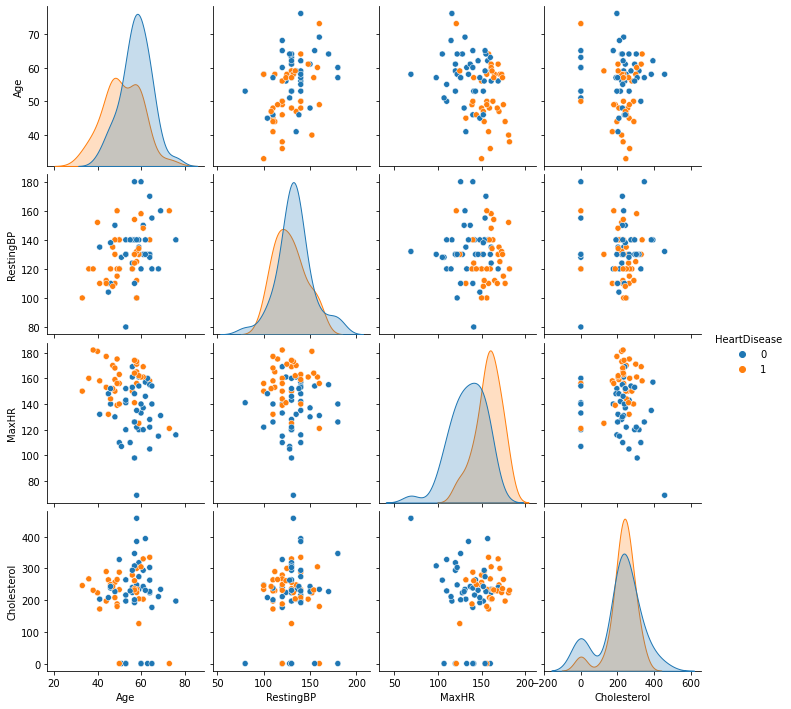

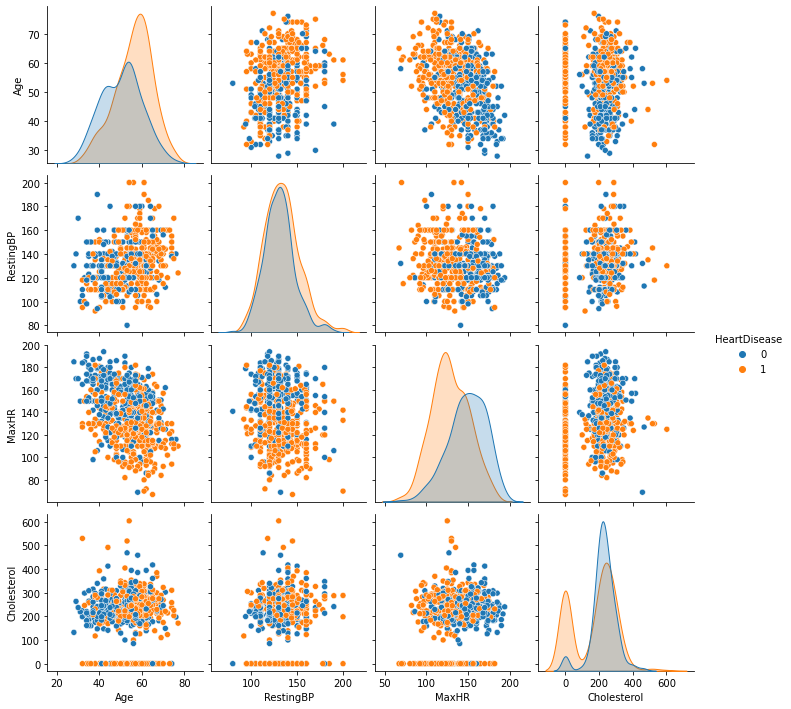

In [67]:
#間違いだけのデータフレーム作成
df_train_wrong=df_train.copy()
df_train_wrong=df_train_wrong.query('ACC==0')

#pairplotの作成,心臓病のありなしで色分け
sns.pairplot(df_train_wrong,vars=numeric_features+['Cholesterol'],hue='HeartDisease')
plt.savefig('./WrongAnswers/LR_dummy1_pca1.png')
sns.pairplot(df_train,vars=numeric_features+['Cholesterol'],hue='HeartDisease')
plt.show()

In [68]:
#正答率と心臓病有り無しの関係
pd.crosstab(df_train['HeartDisease'],df_train['ACC'])

ACC,0,1
HeartDisease,,
0,42,241
1,35,324


#正答率とコレステロール0の関係
pd.crosstab(df_train['chol0'],df_train['ACC'])

In [ ]:
##追加する登頂量のリスト
add_feature_list=['ASY', 'NAP', 'TA+ATA', 'LVH','Normal', 'ST']

add_f=[]
scores=[]
scores_mean=[]

for i in add_feature_list:
    #5分割公差検証
    #変数
    X = df_train[features+[i]]
    Y = df_train[target]

    #交差検証
    score_LC = cross_val_score(clf_LC, X, Y, cv=5)  
    
    add_f.append(i)
    scores.append(score_LC)
    scores_mean.append(score_LC.mean())

for i,name in enumerate(add_feature_list):
    print(f'{name}:scores {scores[i]},mean:{scores_mean[i]}')

In [129]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_train_wrong.query('MaxHR>150')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk,CholCat,Age_z,RestingBP_z,MaxHR_z,cpt_l,recg_l,H_risk_l,Chol_l,chol_l,y_pred,ACC
5,64,1,NAP,140,335,0,Normal,158,0,0.0,Up,1,Risk0,chol3,1.095304,0.438999,0.837400,0,0,0,NaN,2,0,0
10,56,1,TA+ATA,124,224,1,Normal,161,0,2.0,Flat,0,Risk3,chol2,0.256306,-0.450253,0.959326,1,0,3,NaN,1,1,0
12,61,0,ASY,130,330,0,LVH,169,0,0.0,Up,1,Risk0,chol3,0.780680,-0.116784,1.284461,2,1,0,NaN,2,0,0
36,59,1,ASY,135,234,0,Normal,161,0,0.5,Flat,0,Risk3,chol2,0.570930,0.161108,0.959326,2,0,3,NaN,1,1,0
72,47,0,NAP,135,248,1,Normal,170,0,0.0,Flat,1,Risk2,chol2,-0.687567,0.161108,1.325103,0,0,2,NaN,1,0,0
75,56,1,TA+ATA,120,240,0,Normal,169,0,0.0,Down,0,Risk2,chol2,0.256306,-0.672566,1.284461,1,0,2,NaN,1,1,0
90,50,1,NAP,140,233,0,Normal,163,0,0.6,Flat,1,Risk3,chol2,-0.372942,0.438999,1.040610,0,0,3,NaN,1,0,0
94,58,1,NAP,112,230,0,LVH,165,0,2.5,Flat,1,Risk4,chol2,0.466055,-1.117191,1.121893,0,1,4,NaN,1,0,0
107,58,1,ASY,125,300,0,LVH,171,0,0.0,Up,1,Risk0,chol2,0.466055,-0.394675,1.365745,2,1,0,NaN,1,0,0
110,40,1,ASY,152,223,0,Normal,181,0,0.0,Up,1,Risk0,chol2,-1.421690,1.105937,1.772164,2,0,0,NaN,1,0,0
